# Vehicle Detection Project

The goals / steps of this project are the following:

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Settings

In [1]:
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = 32
hist_bins = 32

conv='RGB2YCrCb'
hist_bin_range = (0, 255)

# max 5068
training_size = 5068

figure_size = (16, 16)

### Imports

In [2]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle

from skimage.feature import hog
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

from tqdm import tqdm

### Functions

In [3]:
def convert_color(img, conv):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2GRAY':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

def bin_spatial(img, size, conv, channel):
    img = convert_color(img, conv=conv)
    color = cv2.resize(img[:,:,channel], size).ravel()
    return color
                        
def color_hist(img, nbins, bins_range, conv, channel):
    img = convert_color(img, conv=conv)
    
    # Compute the histogram of the color channels separately
    channel_hist = np.histogram(img[:,:,channel], bins=nbins, range=bins_range)
    hist_features = channel_hist[0]
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img_tosearch, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    result=[]
    
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                result.append([(xbox_left, ytop_draw),(xbox_left+win_draw,ytop_draw+win_draw)]) 
                
    return result

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Initialization

In [4]:
car_images = []
non_car_images = []

print('Reading test images...')
test_images = []
test_image_paths = glob.glob('test_images/*.jpg')
for test_image_path in tqdm(test_image_paths):
    img = mpimg.imread(test_image_path, format='JPG')
    test_images.append(img)
    
print('Reading', training_size, 'random car images...')
car_image_paths = glob.glob('training_images/cars/*.png')
np.random.shuffle(car_image_paths)
for car_image_path in tqdm(car_image_paths[:training_size]):
    img = mpimg.imread(car_image_path, format='PNG')
    car_images.append(img)

print('Reading', training_size, 'random non-car images...')
non_car_image_paths = glob.glob('training_images/non_cars/*.png')
np.random.shuffle(non_car_image_paths)
for non_car_image_path in tqdm(non_car_image_paths[:training_size]):
    img = mpimg.imread(non_car_image_path, format='PNG')
    non_car_images.append(img)

assert len(car_images) == training_size
assert len(non_car_images) == training_size

Reading test images...


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 44.07it/s]


Reading 5068 random car images...


100%|████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:02<00:00, 2043.55it/s]


Reading 5068 random non-car images...


100%|████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:02<00:00, 2439.05it/s]


### Feature Extractions

##### Histogram of Oriented Gradients (HOG) feature extraction

Getting HOG features for each car image...


100%|█████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:10<00:00, 504.54it/s]


Getting HOG features for each non-car image...


100%|█████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:09<00:00, 559.15it/s]


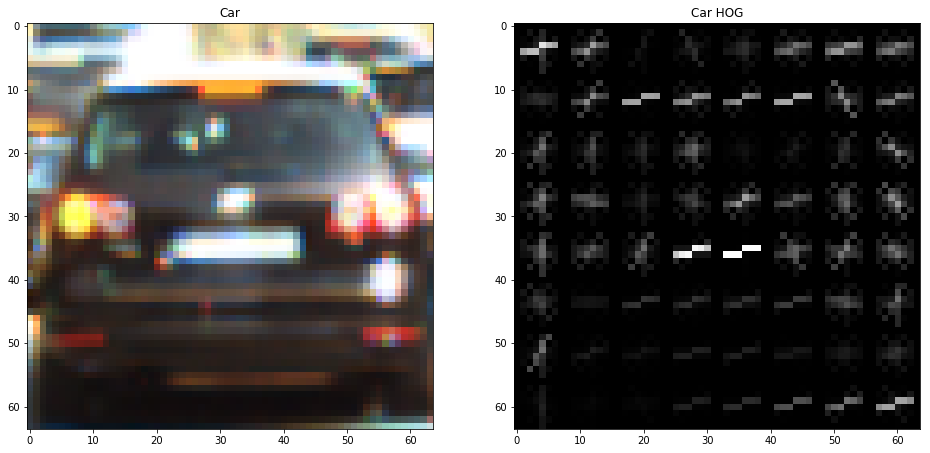

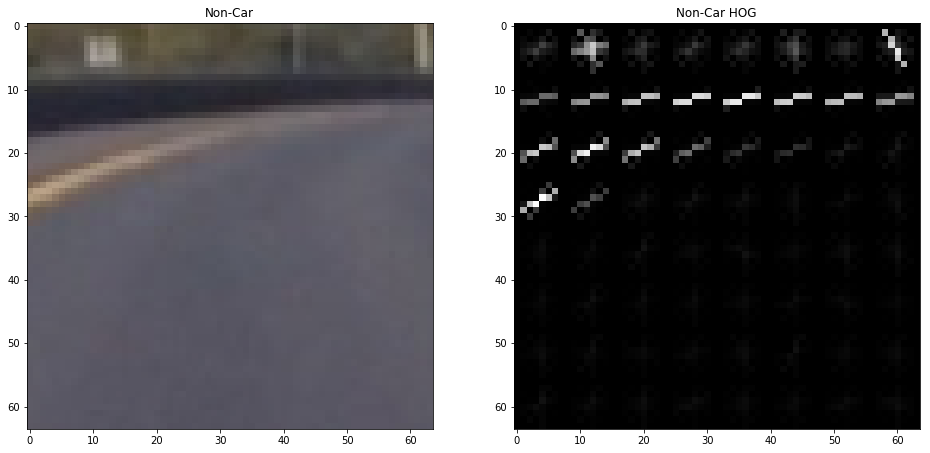

In [5]:
car_hog_features_list = []
non_car_hog_features_list = []

def show_example(title, img):
    f = plt.figure(figsize=figure_size)        
    f.add_subplot(1,2,1)
    plt.title(title)
    plt.imshow(img)

    _, hog_image = get_hog_features(convert_color(img, 'RGB2GRAY'), orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    f.add_subplot(1,2,2)
    plt.title('{} HOG'.format(title))
    plt.imshow(hog_image, cmap='gray')

print('Getting HOG features for each car image...')
for img in tqdm(car_images):    
    gray_img = convert_color(img, 'RGB2GRAY')
    features = get_hog_features(gray_img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    car_hog_features_list.append(features)  

assert len(features.shape) == 1

#Example - Car
show_example('Car', car_images[-1])

print('Getting HOG features for each non-car image...')
for img in tqdm(non_car_images):    
    gray_img = convert_color(img, 'RGB2GRAY')
    features = get_hog_features(gray_img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    non_car_hog_features_list.append(features)  

assert len(features.shape) == 1

#Example - Non-Car
show_example('Non-Car', non_car_images[-1])



##### Binned color spatial feature extraction

Getting binned spartial features for each car image...


100%|███████████████████████████████████████████████████████████████████████████| 5068/5068 [00:00<00:00, 13059.61it/s]


Getting binned spartial features for each non-car image...


100%|███████████████████████████████████████████████████████████████████████████| 5068/5068 [00:00<00:00, 13655.01it/s]


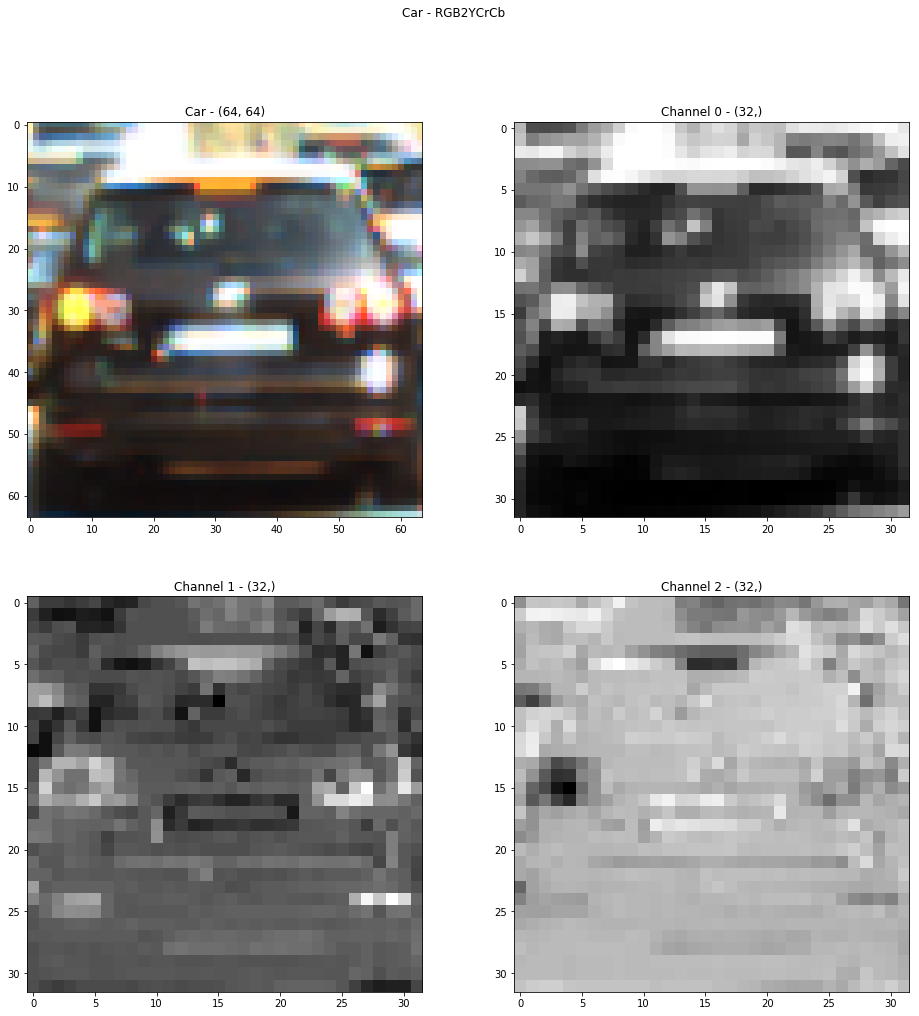

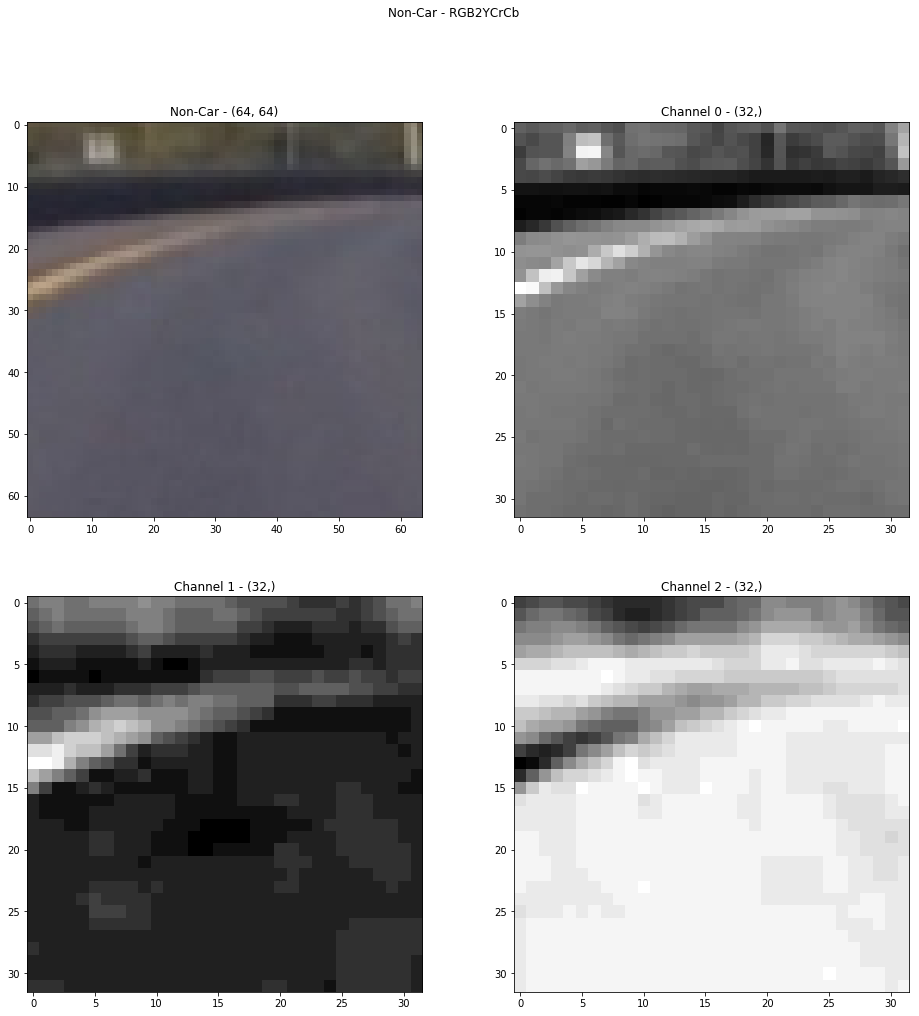

In [6]:
car_bin_features_list = []
non_car_bin_features_list = []

def show_example(title, img, features_c0, features_c1, features_c2):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figure_size)
    f.suptitle('{} - {}'.format(title, conv))
    
    ax1.set_title('{} - {}'.format(title, img.shape[:2]))
    ax1.imshow(img)

    img_c0 = features_c0.reshape((spatial_size, spatial_size))
    ax2.set_title('Channel {} - {}'.format(0, img_c0[-1].shape))
    ax2.imshow(img_c0, cmap='gray')

    img_c1 = features_c1.reshape((spatial_size, spatial_size))
    ax3.set_title('Channel {} - {}'.format(1, img_c1[-1].shape))
    ax3.imshow(img_c1, cmap='gray')

    img_c2 = features_c2.reshape((spatial_size, spatial_size))
    ax4.set_title('Channel {} - {}'.format(2, img_c1[-1].shape))
    ax4.imshow(img_c2, cmap='gray')


print('Getting binned spartial features for each car image...')
for img in tqdm(car_images): 
    features_c0 = bin_spatial(img, size=(spatial_size, spatial_size), conv=conv, channel=0)
    features_c1 = bin_spatial(img, size=(spatial_size, spatial_size), conv=conv, channel=1)
    features_c2 = bin_spatial(img, size=(spatial_size, spatial_size), conv=conv, channel=2)
    features = np.hstack([features_c0, features_c1, features_c2])
    car_bin_features_list.append(features)

assert len(features.shape) == 1

#Example - Car
show_example('Car', car_images[-1], features_c0, features_c1, features_c2)

print('Getting binned spartial features for each non-car image...')
for img in tqdm(non_car_images): 
    features_c0 = bin_spatial(img, size=(spatial_size, spatial_size), conv=conv, channel=0)
    features_c1 = bin_spatial(img, size=(spatial_size, spatial_size), conv=conv, channel=1)
    features_c2 = bin_spatial(img, size=(spatial_size, spatial_size), conv=conv, channel=2)   
    features = np.hstack([features_c0, features_c1, features_c2])
    non_car_bin_features_list.append(features)

assert len(features.shape) == 1

#Example - Non-Car
show_example('Non-Car', non_car_images[-1], features_c0, features_c1, features_c2)

assert len(car_hog_features_list) == len(car_bin_features_list)
assert len(non_car_hog_features_list) == len(non_car_hog_features_list)

##### Color histogram feature extraction

Getting color histogram features for each car image...


100%|████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:02<00:00, 2021.84it/s]


Getting color histogram features for each non-car image...


100%|████████████████████████████████████████████████████████████████████████████| 5068/5068 [00:02<00:00, 2024.66it/s]


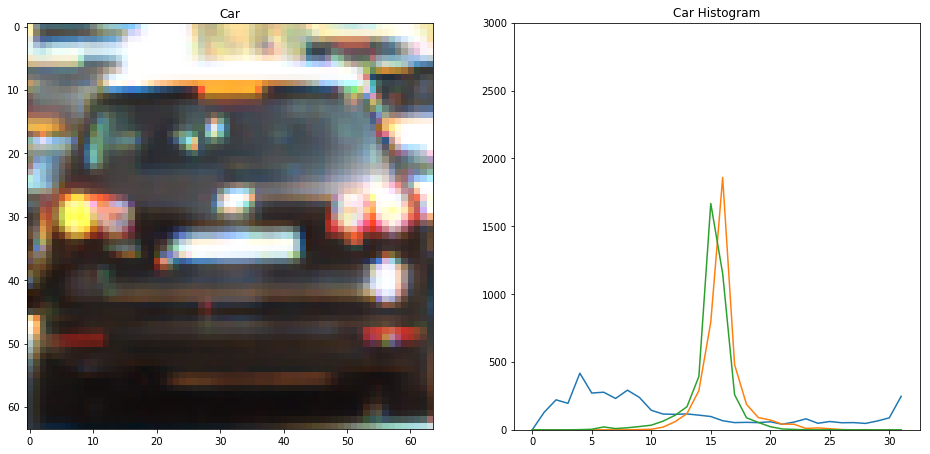

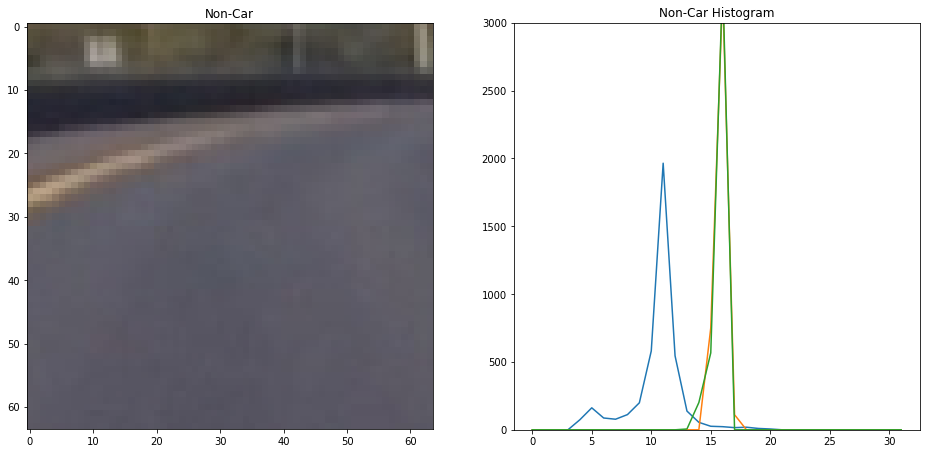

In [7]:
car_hist_features_list = []
non_car_hist_features_list = []

def show_example(title, img, features):
    f = plt.figure(figsize=figure_size)        
    f.add_subplot(1,2,1)
    plt.title(title)
    plt.imshow(img)

    ax = f.add_subplot(1,2,2)
    plt.title('{} Histogram'.format(title))
    ax.set_aspect(.0114)
    plt.plot(features.reshape((-1, hist_bins)).T)
    ax.set_ylim((0, 3000))

print('Getting color histogram features for each car image...')
for img in tqdm(car_images):
    features_c0 = color_hist(img, hist_bins, bins_range=hist_bin_range, conv=conv, channel=0)
    features_c1 = color_hist(img, hist_bins, bins_range=hist_bin_range, conv=conv, channel=1)
    features_c2 = color_hist(img, hist_bins, bins_range=hist_bin_range, conv=conv, channel=2)
    features = np.hstack([features_c0, features_c1, features_c2])

    car_hist_features_list.append(features)

assert len(features.shape) == 1

#Example - Car
show_example('Car', car_images[-1], features)

print('Getting color histogram features for each non-car image...')
for img in tqdm(non_car_images):
    features_c0 = color_hist(img, hist_bins, bins_range=hist_bin_range, conv=conv, channel=0)
    features_c1 = color_hist(img, hist_bins, bins_range=hist_bin_range, conv=conv, channel=1)
    features_c2 = color_hist(img, hist_bins, bins_range=hist_bin_range, conv=conv, channel=2)
    features = np.hstack([features_c0, features_c1, features_c2])
    non_car_hist_features_list.append(features)

assert len(features.shape) == 1

#Example - Non-Car
show_example('Non-Car', non_car_images[-1], features)

assert len(car_bin_features_list) == len(car_hist_features_list)
assert len(non_car_hog_features_list) == len(non_car_hist_features_list)

##### Combine and Normalize

100%|███████████████████████████████████████████████████████████████████████████| 5068/5068 [00:00<00:00, 41974.10it/s]


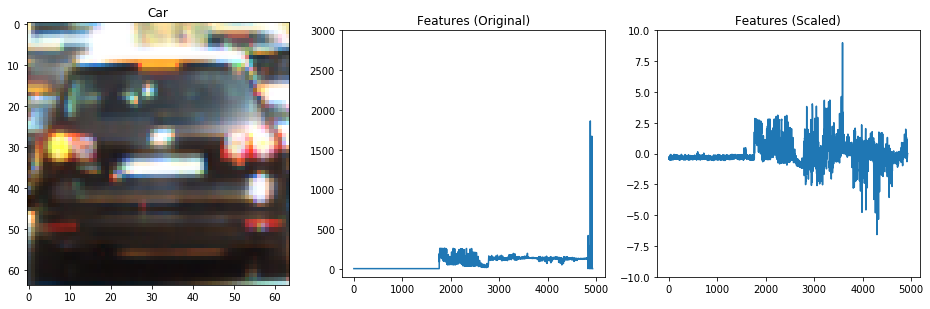

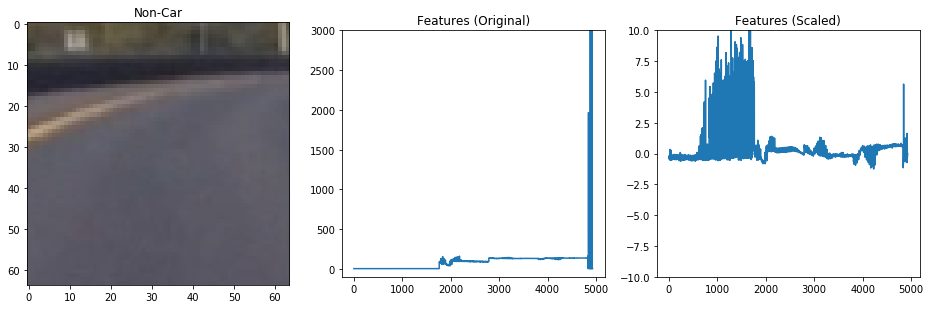

In [8]:
car_features_list = []
non_car_features_list = []

def show_example(title, img, features, scaled_features):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figure_size)
    
    ax1.set_title(title)
    ax1.imshow(img)

    ax2.set_title('Features (Original)'.format(title))
    ax2.set_aspect(1.64)
    ax2.plot(features)
    ax2.set_ylim((-100,3000))

    ax3.set_title('Features (Scaled)'.format(title))
    ax3.set_aspect(256)
    ax3.plot(scaled_features)
    ax3.set_ylim((-10,10))
    

for i in tqdm(range(len(car_images))):
    car_features_list.append(np.hstack([
        car_hog_features_list[i], 
        car_bin_features_list[i], 
        car_hist_features_list[i]
    ]))

assert len(car_features_list[-1].shape) == 1
    
for i in tqdm(range(len(non_car_images))):
    non_car_features_list.append(np.hstack([
        non_car_hog_features_list[i], 
        non_car_bin_features_list[i], 
        non_car_hist_features_list[i]
    ]))
    
assert len(non_car_features_list[-1].shape) == 1

features_list = np.vstack([car_features_list, non_car_features_list]).astype(np.float64)

assert features_list.shape[0] == (training_size * 2)

feature_scaler = StandardScaler().fit(features_list)
scaled_features_list = feature_scaler.transform(features_list)

labels_list = np.hstack([np.ones(len(car_features_list)), np.zeros(len(non_car_features_list))])

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_features_list, labels_list, test_size=0.382, random_state=rand_state)

assert (len(X_train) + len(X_test)) == len(features_list)
assert (len(y_train) + len(y_test)) == len(features_list)

#show example of scaled features
show_example('Car', car_images[-1], features_list[training_size - 1], scaled_features_list[training_size - 1])
show_example('Non-Car', non_car_images[-1], features_list[-1], scaled_features_list[-1])


### Construct and train the classifier

In [9]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[1, 3, 6, 9]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, n_jobs=4, verbose=3)
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
params = clf.best_params_
print('Accuracy = {}, Best Parameters = {}'.format(accuracy, params))

# Best Parameters = {'C': 10, 'kernel': 'rbf'}


#clf = svm.SVC(C=10, kernel='rbf')
#clf.fit(X_train, y_train)
#accuracy = clf.score(X_test, y_test)
#print('Accuracy = {}'.format(accuracy))


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 21.8min finished


Accuracy = 0.9971590909090909, Best Parameters = {'C': 9, 'kernel': 'rbf'}


### Image Test

In [ ]:
test_image_hog_list = []

for img in tqdm(test_images):
    img = img[int(img.shape[0] / 2):,]
    
    f = plt.figure(figsize=figure_size)        
    f.add_subplot(1,2,1)
    plt.imshow(img)
    
    windows = find_cars(img, )